<a href="https://colab.research.google.com/github/IzzyBrand/kiteTrajOpt/blob/master/simple_kite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notebook Setup 
The following cell will install Drake, checkout the underactuated repository, and set up the path (only if necessary).
- On Google's Colaboratory, this **will take approximately two minutes** on the first time it runs (to provision the machine), but should only need to reinstall once every 12 hours.  Colab will ask you to "Reset all runtimes"; say no to save yourself the reinstall.
- On Binder, the machines should already be provisioned by the time you can run this; it should return (almost) instantly.

More details are available [here](http://underactuated.mit.edu/drake.html).

In [1]:
try:
    import pydrake
    import underactuated
    print('ok')
except ImportError:
    print('failed')
    !curl -s https://raw.githubusercontent.com/RussTedrake/underactuated/master/scripts/setup/jupyter_setup.py > jupyter_setup.py
    from jupyter_setup import setup_underactuated
    setup_underactuated()

# Setup matplotlib backend (to notebook, if possible, or inline).  
from underactuated.jupyter import setup_matplotlib_backend
plt_is_interactive = setup_matplotlib_backend()

failed


In [2]:
# python libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# pydrake imports
from pydrake.all import (Variable, SymbolicVectorSystem, DiagramBuilder,
                         LogOutput, Simulator, ConstantVectorSource,
                         MathematicalProgram, Solve, SnoptSolver, PiecewisePolynomial)
import pydrake.symbolic as sym
from pydrake.common.containers import namedview
from pydrake.systems.framework import (BasicVector, LeafSystem, PublishEvent,
                                       PortDataType, UnrestrictedUpdateEvent,
                                       WitnessFunctionDirection)

In [3]:
KiteState = namedview('KiteState', ['theta', 'phi', 'thetadot', 'phidot'])

class DrakeKite(LeafSystem):
    def __init__(self, kite):
        LeafSystem.__init__(self)
        self.r = 100.  # length of the cable in meters
        self.mass = 1  # kg
        self.g = 9.81  # m/s^2
        self.kite = kite
        self.w = np.array([10, 0, 0])
        
        self.DeclareContinuousState(4)
        self.DeclareVectorInputPort("u", BasicVector(1))
        self.DeclareVectorOutputPort("y", BasicVector(4), self.CopyStateOut)

    def DoCalcTimeDerivatives(self, context, derivatives):
        x = KiteState(context.get_continuous_state_vector().CopyToVector())
        theta, phi, thetadot, phidot = x
        u = self.EvalVectorInput(context, 0).CopyToVector()
        xdot = self.kite.f(x, u, self.w)
        derivatives.get_mutable_vector().SetFromVector(xdot)
        
    def CopyStateOut(self, context, output):
        x = context.get_continuous_state_vector().CopyToVector()
        y = output.SetFromVector(x)


In [4]:
class Kite:
    def __init__(self):
        self.r = 50.    # length of the cable in meters
        self.m = 1      # kg
        self.g = 9.81   # m/s^2
        self.rho = 1.2  # air density
        self.A = 0.5    # kite surface area (m^2)
        self.C_l = 1.5  # coeff of lift
        self.C_d = 0.29 # coeff of drag

    def p(self, x):
        """ get the kite position in global frame
        """
        theta, phi, _, _ = x

        s_t = np.sin(theta)
        c_t = np.cos(theta)
        s_p = np.sin(phi)
        c_p = np.cos(phi)

        x = self.r*s_t*c_p
        y = self.r*s_t*s_p
        z = self.r*c_t
        return np.array([x,y,z])

    def pdot(self, x):
        """ get the kite velocity in global frame
        """
        theta, phi, thetadot, phidot = x

        s_t = np.sin(theta)
        c_t = np.cos(theta)
        s_p = np.sin(phi)
        c_p = np.cos(phi)

        xdot = self.r*(c_t*c_p*thetadot - s_t*s_p*phidot)
        ydot = self.r*(c_t*s_p*thetadot + s_t*c_p*phidot)
        zdot = self.r*(-s_t*thetadot)

        return np.array([xdot, ydot, zdot])

    def e_l(self, x, u, w):
        """ the unit vector along the kite longitudinal axis
        """
        w_e =  w - self.pdot(x)
        e_l = w_e/np.linalg.norm(w_e)
        return e_l

    def e_t(self, x, u, w):
        # calculate the kite airspeed vector
        w_e =  w - self.pdot(x)

        # get the basis of the kite string
        e_theta, e_phi, e_r = self.get_string_basis(x)

        # project the wind into the plane of the kite
        w_p_e = w_e - e_r * np.dot(e_r, w_e)
        w_p_e_norm = np.linalg.norm(w_p_e)
        e_w = w_p_e/w_p_e_norm

        # get a vector perpendicular to the wind (sorta)
        # in the plane of the kite
        e_o = np.cross(e_r, e_w)

        # get the angle of the kite (defined by airspeed)????
        nu = np.arcsin(np.dot(w_e, e_r)/w_p_e_norm*np.tan(u))

        # the basis in the plane of the kite pointing sideways (transverse)
        # accounting for kite roll
        e_t = e_w*(-np.cos(u)*np.sin(nu)) +\
            e_o*(np.cos(u)*np.cos(nu)) +\
            e_r*np.sin(u)

        return e_t

    def get_string_basis(self, x):
        """ get a coordinate frame rotated by the kite's position
        """
        theta, phi, _, _ = x
        s_t = np.sin(theta)
        c_t = np.cos(theta)
        s_p = np.sin(phi)
        c_p = np.cos(phi)

        e_theta = np.array([c_t*c_p, c_t*s_p, -s_t])
        e_phi = np.array([-s_p, c_p, 0])
        e_r = np.array([s_t*c_p, s_t*s_p, c_t])
    
        return np.array([e_theta, e_phi, e_r])

    def F_theta_aer(self, x, u, w):
        """ the total aerodynamic force on azimuth
        """
        F_l = self.F_l(x, u, w)
        F_d = self.F_d(x, u, w)

        # get the basis of the kite string
        e_theta, e_phi, e_r = self.get_string_basis(x)

        e_l = self.e_l(x, u, w)
        e_t = self.e_t(x, u, w)

        F_theta_aer = F_l * (np.cross(e_l, e_t).T @ e_theta) +\
            F_d * (e_l.T @ e_theta)
        return F_theta_aer
    
    def F_phi_aer(self, x, u, w):
        """ the total aerodynamic force on elevation
        """
        F_l = self.F_l(x, u, w)
        F_d = self.F_d(x, u, w)

        # get the basis of the kite string
        e_theta, e_phi, e_r = self.get_string_basis(x)

        e_l = self.e_l(x, u, w)
        e_t = self.e_t(x, u, w)

        F_phi_aer = F_l * (np.cross(e_l, e_t).T @ e_phi) + F_d*(e_l.T @ e_phi)

        return F_phi_aer

    def F_l(self, x, u, w):
        """ force frome lift
        """
        w_e =  w - self.pdot(x)
        return 1/2 * self.rho * (w_e.T@w_e) * self.A * self.C_l

    def F_d(self, x, u, w):
        """ force from drag
        """
        w_e =  w - self.pdot(x)
        return 1/2 * self.rho * (w_e.T@w_e) * self.A * self.C_d

    def f(self, x, u, w=np.array([1,0,0])):
        """ dynamics of the kite
        """
        theta, phi, thetadot, phidot = x
    
        thetadotdot = self.F_theta_aer(x, u, w)/(self.r*self.m) +\
            np.sin(theta)*self.g/self.r +\
            np.sin(theta)*np.cos(theta)*phidot**2

        phidotdot = self.F_phi_aer(x, u, w)/(self.r*self.m) -\
            2/np.tan(theta)*phidot*thetadot

        xdot = np.array([thetadot, phidot, thetadotdot, phidotdot])

        return xdot


In [5]:
theta = 1e-5
phi = np.pi/4
thetadot = 0
phidot = 0

x_0 = np.array([theta, phi, thetadot, phidot])
w = np.array([6, 0, 0])
u = -np.pi/8

In [6]:
kite = Kite()
kite.f(x_0,u,w)

array([0.       , 0.       , 0.1319674, 0.0433821])

In [7]:
from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.primitives import LogOutput
from pydrake.systems.drawing import plot_system_graphviz


In [8]:
x = Variable("x")
const_u_sys = SymbolicVectorSystem(state=[x], dynamics=[0], output=[x])

<IPython.core.display.Javascript object>


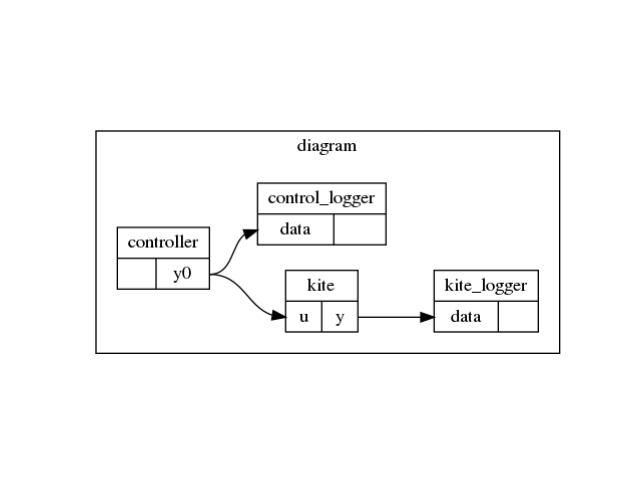

In [9]:
# create simple block diagram containing our system
builder = DiagramBuilder()

kite_system = builder.AddSystem(DrakeKite(kite))
kite_system.set_name("kite")

controller = builder.AddSystem(const_u_sys)
controller.set_name("controller")

builder.Connect(controller.get_output_port(0), kite_system.get_input_port(0))

logger_kite = LogOutput(kite_system.get_output_port(0), builder)
logger_kite.set_name("kite_logger")

logger_control = LogOutput(controller.get_output_port(0), builder)
logger_control.set_name("control_logger")

diagram = builder.Build()
diagram.set_name("diagram")

plt.figure()
plot_system_graphviz(diagram, max_depth=2)



In [13]:
# set initial conditions, x(0)
theta = .01
phi = np.pi/4
thetadot = 0
phidot = 0

context = diagram.CreateDefaultContext()

kite_context = diagram.GetMutableSubsystemContext(kite_system, context)
x0 = [theta, phi, thetadot, phidot]
kite_context.SetContinuousState(x0)

controller_context = diagram.GetMutableSubsystemContext(controller, context)
controller_context.SetContinuousState([0])

<IPython.core.display.Javascript object>


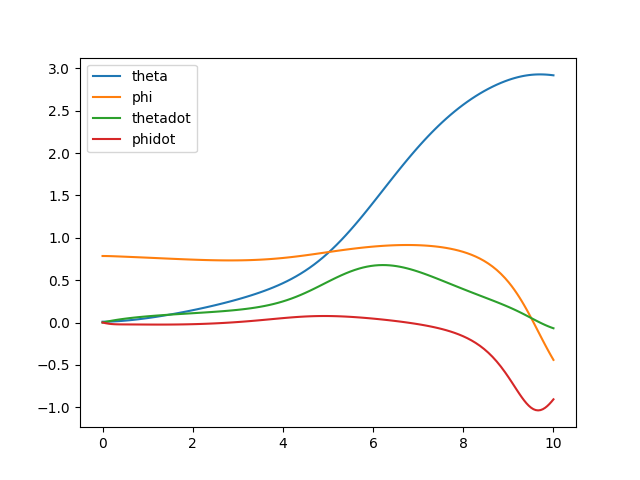

(4, 124)


In [11]:
simulator = Simulator(diagram, context)
simulator.AdvanceTo(10)

plt.figure()
print(logger_kite.data().shape)
plt.plot(logger_kite.sample_times(), logger_kite.data().transpose())
plt.legend(['theta', 'phi', 'thetadot', 'phidot'])

<IPython.core.display.Javascript object>


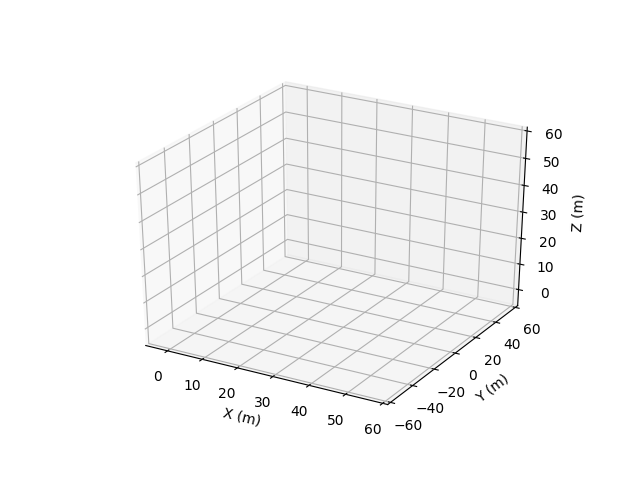

In [14]:
from vis import animate_trajectory
(_, T) = logger_kite.data().shape
W = np.ones([T,3]) * np.array([6, 0, 0])[None,:]
U = logger_control.data().transpose()
X = logger_kite.data().transpose()
animate_trajectory(X, U, W)